In [1]:
import os


import numpy as np

from dynamic_programming.policy_iteration import PolicyIteration, PolicyIterationTorch
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from base_algorithm.eval_policy import EvalDiscreteStatePolicy
import time
import pandas as pd

## Load Data and MDP Model

In [2]:
device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'tmp/dynamic_programming/mdp_model.pkl'
sa_reward = False
samples = np.load(load_path,allow_pickle=True)[()]


print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

-313.560969726944
20000
0.0
815


In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)


Computing Reward Function
Computing Transition Model
0.5927894115447998


In [4]:
mdp_model.save(mdp_save_path)

In [5]:
mdp_model = MDPModel.load(mdp_save_path)

## Train

In [6]:
mdp_model.reward_function.shape

(816,)

In [7]:
mdp_model.reward_function

array([1036.2654 , 1039.7545 , 1111.1475 , 1102.9496 , 1069.8312 ,
       1124.3975 , 1147.7473 , 1115.8939 , 1112.4489 , 1049.0814 ,
        948.5144 , 1046.0912 , 1124.157  ,  982.0958 , 1100.7155 ,
       1086.3888 , 1086.8218 , 1114.5444 , 1095.9008 , 1130.9786 ,
       1129.6628 , 1007.23517,  895.8153 ,  927.9494 , 1013.1126 ,
       1075.1613 , 1060.3805 , 1074.9575 , 1075.6012 , 1093.5704 ,
       1149.4203 , 1047.2686 , 1062.2794 , 1081.883  , 1089.8322 ,
       1155.1344 , 1096.7185 , 1123.7941 , 1126.9354 , 1144.2578 ,
       1124.3937 , 1013.2797 , 1034.0791 ,  945.1551 ,  998.9376 ,
       1037.0645 ,  909.4895 , 1084.5288 , 1086.2079 , 1049.1483 ,
       1081.6666 , 1113.9097 , 1109.7197 , 1106.7084 , 1109.8192 ,
       1042.6029 , 1153.8724 ,  924.54785, 1098.962  , 1138.4269 ,
        975.88885, 1131.5669 , 1100.085  , 1044.6763 , 1111.4652 ,
        939.70465, 1035.0555 , 1045.9894 , 1087.8657 ,  979.4192 ,
       1011.81616, 1131.8463 , 1059.7076 , 1141.6145 , 1067.81

2681.6217761827447
1982.265933283365
1978.3033836827317
1974.348755218749
1970.4020320570671
1966.4631983949857
1962.5322384613937
1958.6091365167104
1954.6938768528125
1950.786443792982
1946.8868216918418
1942.9949949352776
1939.110947940404
1935.2346651554726
1931.3661310598254
1927.5053301638363
1923.6522470088385
1919.8068661670695
1915.9691722416028
1912.1391498662852
1908.3167837057044
1904.5020584550803
1900.6949588402276
1896.895469617506
1893.1035755737394
1889.319261526165
1885.5425123223758
1881.773312840247
1878.011647987878
1874.257502703549
1870.5108619556486
1866.7717107425924
1863.0400340928245
1859.3158170646711
1855.5990447463555
1851.8897022559104
1848.1877747411054
1844.4932473793888
1840.8061053778802
1837.126333973225
1833.453918431609
1829.7888440486713
1826.1310961494164
1822.4806600882148
1818.8375212487008
1815.2016650437145
1811.5730769153015
1807.9517423345533
1804.3376468016213
1800.730775845659
1797.1311150247493
1793.5386499258166
1789.9533661646128
1786.

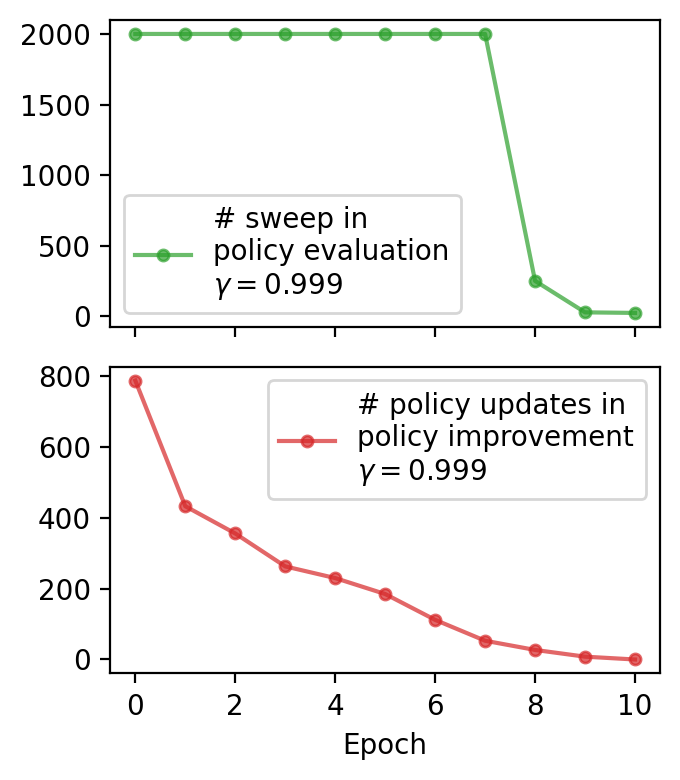

In [17]:
solver = PolicyIteration(mdp_model.reward_function, mdp_model.transition_model, gamma=0.999, sa_reward=sa_reward)
solver.train(total_epochs=100,eval_epochs=2000)
policy_save_path = 'tmp/dynamic_programming/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.policy, state_to_index=mdp_model.state_to_index,
                        index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [18]:
print(solver.values)


[1157743.86500903 1158464.52507185 1158429.73404253 1158884.10151175
 1158940.09211363 1158960.09566835 1158314.16514359 1158986.15485777
 1158948.14710731 1158901.87302818 1158203.93797953 1159029.29032192
 1158913.35594263 1158965.29496059 1158825.93286434 1158753.49572542
 1158843.58600898 1158915.68000627 1158285.83333491 1158887.74296396
 1157960.53771237 1158386.68668684 1158124.11530777 1158421.19922471
 1158031.94500484 1158945.42228648 1158680.50176034 1158676.87411367
 1158778.90026197 1158760.67736604 1158878.27550909 1158583.35400369
 1158851.47837915 1158729.2833994  1158592.3258634  1158911.89872568
 1158853.48283213 1158880.55839365 1158662.14750264 1158901.02213877
 1158397.14679791 1158515.44425231 1158415.09761225 1158053.6350278
 1158515.7730496  1158539.5581632  1158266.7467785  1158806.20664385
 1158661.15495938 1158696.54875264 1158593.43104121 1158835.58750323
 1158632.79155577 1158595.5304337  1158003.34493548 1158000.34876738
 1158054.7934551  1158054.84508385 

In [19]:


steps_per_episode = 1000
env_kwargs = {'steps_per_episode': steps_per_episode,'device':device, 'config':None}

policy = DPPolicy.load(policy_save_path)
algo = EvalDiscreteStatePolicy(policy=policy,env_creator=env_creator,env_kwargs=env_kwargs)

Episode 9 Reward: -448.7876425900065 || New State Found: True


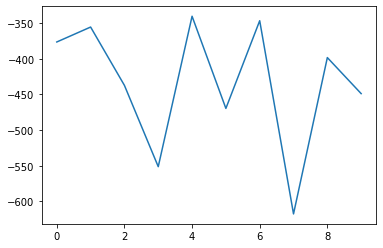

In [20]:
algo.evaluate(epochs=10)

In [21]:
algo.eval_new_state_found

[True, True, True, True, True, True, True, True, True, True]

In [22]:
np.mean(algo.eval_rewards_per_epoch)

-434.11034635421436

In [23]:
np.std(algo.eval_rewards_per_epoch)

87.24258461341198

In [15]:
df = pd.DataFrame(algo.eval_trajectories[0]['info'])
df.head()

,setpoint,velocity,gain,shift,fatigue,consumption,op_cost_t0,op_cost_t1,op_cost_t2,op_cost_t3,...,op_cost_t5,op_cost_t6,op_cost_t7,op_cost_t8,op_cost_t9,ml1,ml2,ml3,hv,hg
0,70,51.0,40.0,50.000000,23.467400,115.499372,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,104.584986,104.584986,84.774942,-1,1,-2.0,0.020876,0.003415
1,70,52.0,30.0,55.751534,32.258667,125.025163,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,104.584986,84.774942,68.717232,-1,1,-1.0,0.057996,0.053394
2,70,53.0,20.0,61.503069,28.518791,122.866853,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,84.774942,68.717232,55.701106,1,1,0.0,0.058989,0.063752
3,70,54.0,20.0,67.254603,30.212256,120.778974,104.584986,104.584986,104.584986,104.584986,...,104.584986,84.774942,68.717232,55.701106,57.974311,1,1,1.0,0.082400,0.076911
4,70,55.0,20.0,73.006137,36.752427,112.350065,104.584986,104.584986,104.584986,104.584986,...,84.774942,68.717232,55.701106,57.974311,60.340288,1,1,2.0,0.082944,0.144346


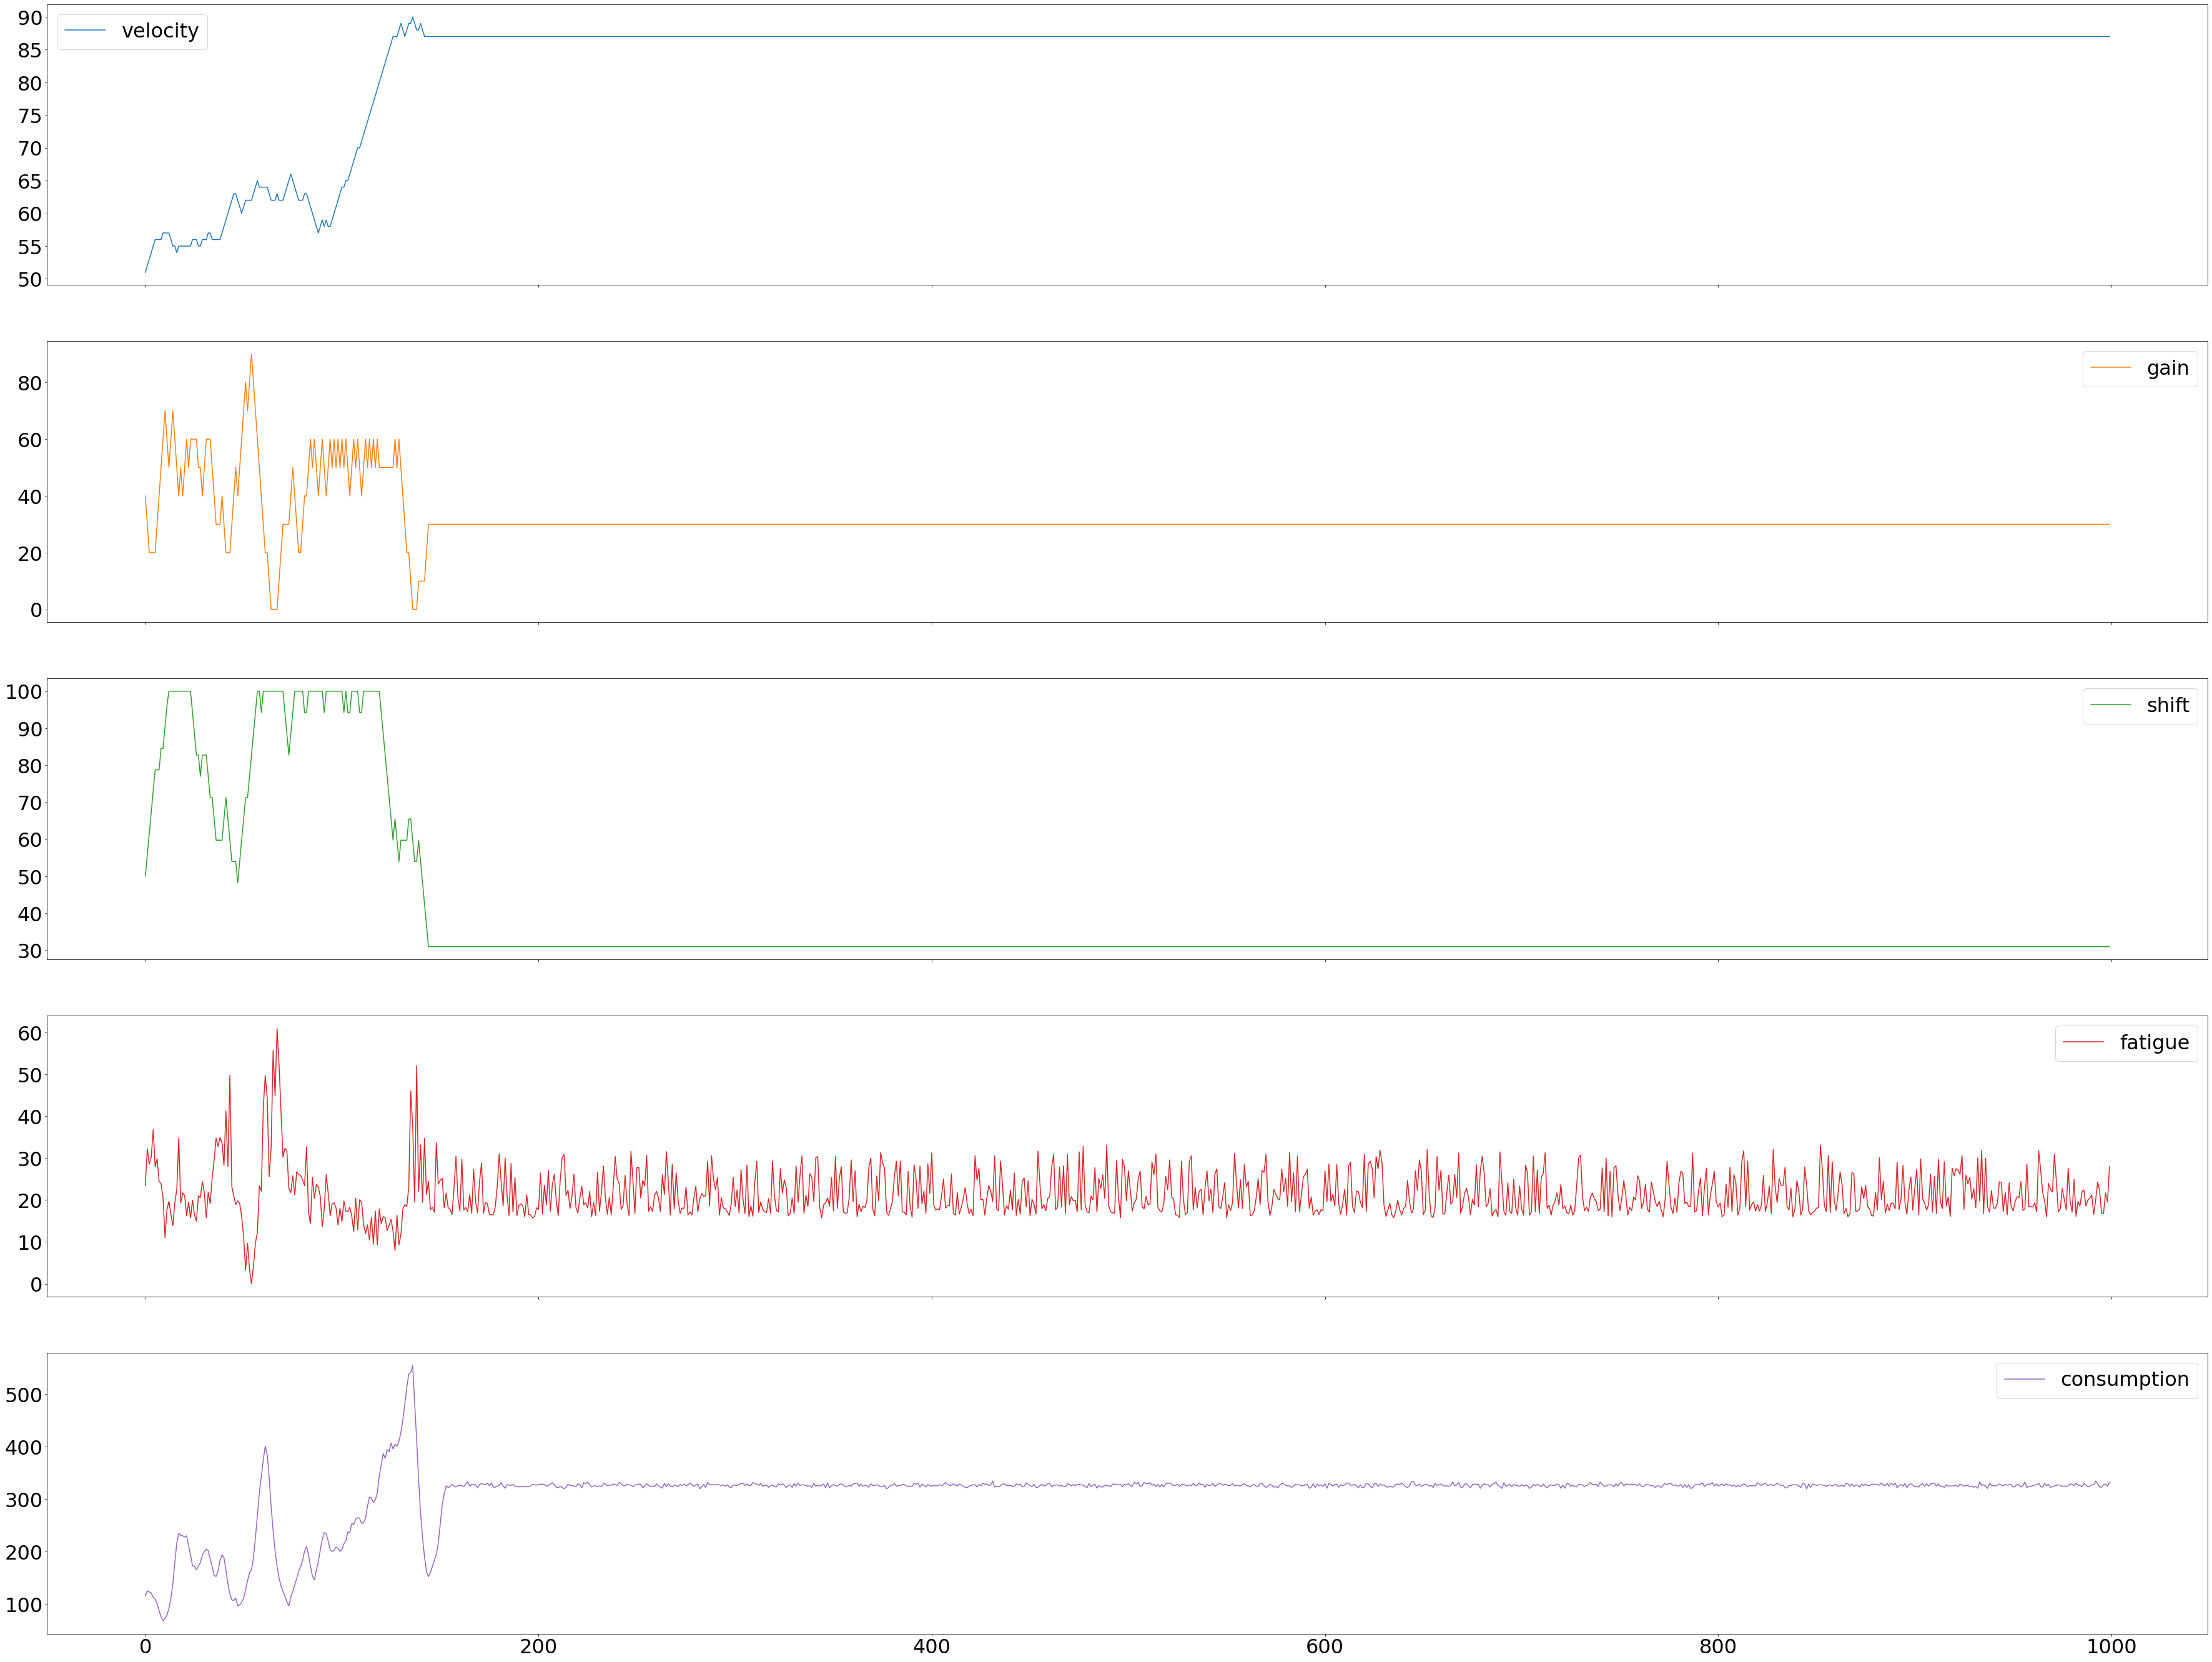

In [16]:
axes = df[['velocity','gain','shift','fatigue','consumption']].plot(subplots=True, figsize=(62, 48), fontsize=32)
for a in axes:
        a.legend(loc='best', prop={'size': 32})